In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load dataset
df = pd.read_csv("/content/air_quality.csv", low_memory=False)
print("Loaded dataset with shape:", df.shape)
print("Columns in dataset:", list(df.columns))

Loaded dataset with shape: (5882208, 25)
Columns in dataset: ['date', 'sitename', 'county', 'aqi', 'pollutant', 'status', 'so2', 'co', 'o3', 'o3_8hr', 'pm10', 'pm2.5', 'no2', 'nox', 'no', 'windspeed', 'winddirec', 'unit', 'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg', 'longitude', 'latitude', 'siteid']


In [ ]:
# 2. Detect station/city column
possible_station_cols = ['station', 'city', 'location', 'Site', 'sitename', 'county']
station_col = None
for col in possible_station_cols:
    if col in df.columns:
        station_col = col
        break

if station_col is None:
    raise ValueError("No column found for station/city name (like 'station', 'city', 'location', 'sitename', or 'county').")

print(f"Detected station column: {station_col}")

Detected station column: sitename


In [ ]:
# 3. Choose a city (or station)
city = "Delhi"
if city not in df[station_col].unique():
    print(f"{city} not found, using:", df[station_col].iloc[0])
    city = df[station_col].iloc[0]

df_city = df[df[station_col] == city].copy()

# 4. Handle datetime
if 'datetime' in df_city.columns:
    df_city['datetime'] = pd.to_datetime(df_city['datetime'], errors='coerce')
else:
    # See if your dataset has these columns, else use 'date'
    date_cols = [c for c in ['year', 'month', 'day', 'hour'] if c in df_city.columns]
    if len(date_cols) == 4:
        df_city['datetime'] = pd.to_datetime(df_city[date_cols])
    elif 'date' in df_city.columns:
        df_city['datetime'] = pd.to_datetime(df_city['date'], errors='coerce')
    else:
        raise ValueError("No datetime information found in dataset.")

df_city = df_city.sort_values('datetime').set_index('datetime')

Delhi not found, using: Hukou


In [ ]:
# 5. Handle PM2.5 column
pollutant_col = "pm2.5"
if pollutant_col not in df_city.columns:
    raise ValueError(f"No column named '{pollutant_col}' found in dataset.")
df_city[pollutant_col] = pd.to_numeric(df_city[pollutant_col], errors='coerce')

# 6. Resample hourly and interpolate
df_hourly = df_city[[pollutant_col]].resample("1h").mean()
df_hourly = df_hourly.interpolate()
print("\nAfter hourly resampling, total rows:", len(df_hourly))
print(df_hourly.head())

# 7. Add previous hour feature
df_hourly[f"{pollutant_col}_prev"] = df_hourly[pollutant_col].shift(1)
df_hourly = df_hourly.dropna()


After hourly resampling, total rows: 68075
                     pm2.5
datetime                  
2016-11-25 13:00:00    9.0
2016-11-25 14:00:00    9.0
2016-11-25 15:00:00    8.0
2016-11-25 16:00:00    8.0
2016-11-25 17:00:00    7.0


In [ ]:
# 8. Train/test split
train_size = int(0.8 * len(df_hourly))
train = df_hourly.iloc[:train_size]
test = df_hourly.iloc[train_size:]

# 9. Train model
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(train[[f"{pollutant_col}_prev"]], train[pollutant_col])

# 10. Predict and evaluate
pred = model.predict(test[[f"{pollutant_col}_prev"]])

rmse = np.sqrt(mean_squared_error(test[pollutant_col], pred))
mae = mean_absolute_error(test[pollutant_col], pred)
r2 = r2_score(test[pollutant_col], pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²:  {r2:.2f}")


Model Evaluation:
RMSE: 4.11
MAE: 2.94
R²:  0.79


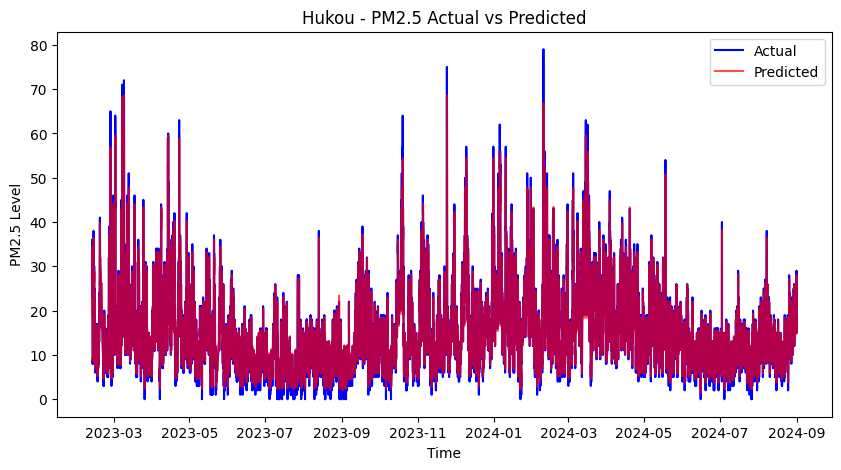

In [ ]:
# 11. Plot
plt.figure(figsize=(10,5))
plt.plot(test.index, test[pollutant_col], label='Actual', color='blue')
plt.plot(test.index, pred, label='Predicted', color='red', alpha=0.7)
plt.title(f"{city} - PM2.5 Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("PM2.5 Level")
plt.legend()
plt.show()